# Monte Carlo Sampling in Bayesian Regression



## Overview

This project exercise focuses on implementing Monte Carlo sampling for computing useful expectations in the Bayesian linear regression model. Primarily it involves the implementation of *importance sampling* and the *Metropolis algorithm* (MCMC). 

The data studied will be synthetic (generated from randomly weighted basis functions) with additive Gaussian noise. The data is to be modelled with the usual linear (in-the-parameters) model, with Gaussian "RBF" basis functions of unspecified width/radius/length-scale $r$. The primary aims of the lab are to estimate $\alpha$, $r$ and, later, the noise $\sigma^2$.

There are three principal tasks. In summary here:

[Task 1](#task1): Compute and visualise the form of the posterior over hyperparameter $\alpha$ and basis function width $r$.

[Task 2](#task2): Implement the importance sampling procedure to estimate the posterior mean width parameter $r$ for the Gaussian "RBF" basis functions in the linear model (given known noise $\sigma^2$). This will involve experimenting with different proposal distributions, and comparing convergence.

[Task 3](#task3): Implement the Metropolis MCMC algorithm to estimate the basis length-scale $r$, again for different proposals. Extend this to estimation of $\sigma^2$, and ultimately to model weights $\mathbf{w}$, thereby computing a mean predictor.



## Setup



In [1]:
##
## Setup
##
%matplotlib inline
# Standard modules
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
# Lab-specific support module
import cm50268_lab2_setup as lab2



We also set some "constants" here: data set sizes and the generative noise standard deviation, which we fix at $\sigma=0.2$ for the entire exercise. Mainly we will assume it is known for modelling purposes, although in one later exercise we will estimate it.

The centres (locations) of the basis functions are fixed here (the length scale, or width, $r$ of those basis functions will be varied during the exercise).


In [2]:
##
## Setup
##
## Define some fixed values
##

# Parameters that determine the generated data
#
sig_gen = 0.2  # Standard deviation
s2_gen = sig_gen**2  # Variance
r_gen = 1  # Basis function width used to generate the data
x_max = 10  # x-limit of the data
#
N_train = 30
N_test = 250

# Parameters that determine the basis set used for modelling
# - note that the length scale "r" will be varied
#
M = 16 # Number of functions, spaced equally
centres = np.linspace(0, x_max, M)


### Generate Data
We synthesise two data sets:
- a training set of size $N=30$ with added noise of std. dev. $\sigma=0.2$
- a test set of size $N=250$ with **no noise**, representing the true function

The "input" $x$ data lies in the range $[0,10]$.

### Generate Basis
For our linear (in-the-parameters) model, we utilise a Gaussian RBF basis function set, where $\phi_m(x; c_m, r) = \exp\{-(x-c_m)^2/r^2\}$. Each basis function has its own center $c_m$; these are equally spaced and will remain fixed. The length scale, or width, $r$ is common across basis functions, and will be varied as part of the lab.

### Example Model Fit
For an arbitrarily selected set of sub-optimal values of $\alpha$, $\sigma^2$ and $r$, the posterior mean predictor is computed and graphed below (using `plot_regresssion`) for illustrative purposes. In particular, it also demonstrates how `RBFGenerator` is used (you will need this).


Measured noise std. dev. = 0.194


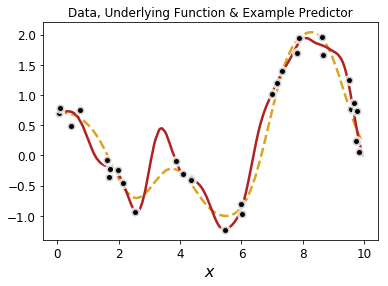

In [3]:
# Generate training data
seed = 4
Data = lab2.DataGenerator(m=9, r=r_gen, noise=sig_gen, rand_offset=seed)
x_train, t_train = Data.get_data('TRAIN', N_train)
x_test, t_test = Data.get_data('TEST', N_test)

# Demonstrate use of basis
r = r_gen * 0.5  # Example model uses basis functions that are too narrow
RBF = lab2.RBFGenerator(centres, r) # centres was fixed earlier
PHI_train = RBF.evaluate(x_train)
PHI_test = RBF.evaluate(x_test)

# Find posterior mean for fixed guesses for alpha and s2
alph = 1e-12
s2 = 0.1**2
mu, _ = lab2.compute_posterior(PHI_train, t_train, alph, s2)
y_test = PHI_test @ mu

# Show the training data and generating function, plus our mean fit
lab2.plot_regression(x_train, t_train, x_test, t_test, y_test)
plt.title("Data, Underlying Function & Example Predictor")
pass 

# Overall Objective

The estimation of a "good" value for the basis function width parameter $r$ given our training data.

This is not a "strictly Bayesian" objective. Ideally, of course, we would make predictions by *integrating* over $r$, but we might imagine that when our model is deployed (as can often be the case in real world applications), there won't be the opportunity to undertake any extended Bayesian computations (*e.g.* running sampling algorithms to calculate predictive distributions in real time). So we are taking a pragmatic viewpoint, and considering how we might find a single good setting for our basis function length-scale.

Our model takes the standard form of $y = \sum_m^M w_m \phi_m(x)$, a linearly-weighted sum of basis functions as defined above: $\phi_m(x; c_m, r) = \exp\{-(x-c_m)^2/r^2\}$. These basis functions have fixed locations $c_m$; but we are free to adjust the common length-scale $r$.

So we will employ our Bayesian techniques now, in the "model development" phase, to determine a good value of $r$ that might be used in any ultimate model. Following good Bayesian practice, we will estimate the optimal values by integrating out (averaging over) the other unknowns (the "nuisance variables"). Because most of the integrations are analytically intractable, we will need to utilise sampling techniques, and this aspect is the focus of Lab 2.


## Task 1: Computing & Visualising the Hyperparameter Posterior <a name="task1"></a>


Assume for now that the data noise variance $\sigma^2=0.2^2$ is a known quantity, and for clarity we will omit it from the probability distribution notation below. We will look at estimating $\sigma^2$ later in the lab (in Task 3, using the Metropolis MCMC algorithm).



### Task 1a

The first thing to do is to write a function to compute $p(\alpha, r | \mathbf{t})$, where $\mathbf{t}$ is the training data (vector) `t_train`. Using Bayes' rule:

$$p(\alpha, r | \mathbf{t}) = \frac{p(\mathbf{t}|\alpha,r)\, p(\alpha)\, p(r)}{p(\mathbf{t})}$$

We cannot compute this analytically, as the denominator $p(\mathbf{t})$ is intractable. But to visualise its shape, we can calculate the numerator, which we typically refer to as $P^\ast(\alpha, r)$. The first term in the numerator $p(\mathbf{t}|\alpha,r)$ is the marginal likelihood calculated in Lab 1 previously (though note the dependence on $r$, which will change $\Phi$). The second two terms are priors for $\alpha$ and $r$. These are both scale parameters, so it is appropriate to use an uninformative, uniform prior, *on a log scale*. As such, *those terms can be treated as constant and ignored*, provided we work with $\log\alpha$ and $\log r$ in our sampling. So, $p(\alpha, r | \mathbf{t}) \propto p(\mathbf{t}|\alpha,r)$, and we only need compute the latter.

It is suggested that the log p.d.f., $\log p(\alpha, r | \mathbf{t})$, is computed by a function of the form: `log_prob_alph_r_given_t(alph, r, s2, x, t, centres)`. If the probability itself is required, this can be obtained by exponentiating.

This function will need to create a new `RBFGenerator` object and recompute the basis matrix (as this changes with $r$), then call `compute_log_marginal()` as appropriate.


In [4]:
#### Task 1a

#### Your implementation of log_prob_alph_r_given_t

def log_prob_alph_r_given_t(alph, r, s2, x, t, centres):
    
    """This function returns the log marginal probablilties
       for given values of alpha, r and s2.
       
       Arguments
       ---------
       alph: alpha
       r
       s2: sigma-squared
       x: x_train/test
       t: t_test/train
       centres
       
       Returns
       -------
       logML: log Marginal Probabilities
       """
    
    RBF = lab2.RBFGenerator(centres, r) 
    PHI = RBF.evaluate(x)
    logML = lab2.compute_log_marginal(PHI, t, alph, s2)
    return logML

### Task 1b

Visualise $p(\alpha, r | \mathbf{t})$, and its logarithm, as implemented in Task 1a.

The following is the approach:

- Compute this function over a regular *logarithmic* grid of $\alpha$ and $r$ values
- For consistency and interpretability, use decimal logs (so `x = np.log10(r)` and `r = 10**x`)
- (Decimal logs apply only to the parameter values: you should still use natural, exponential, logs for log probabilities!)
- Suggested ranges are:
    - $\log_{10}\alpha \in [-9,+6]$
    - $\log_{10} r \in [-2,+2]$
- Visualise the resultant matrix of $\log p(\mathbf{t}|\alpha,r)$ with `plt.contour()`, `plt.contourf()` or similar function (using logarithmic values for $\alpha$ and $r$)
- Arrange it so that $\log\alpha$ is on the horizontal axis, $\log r$ on the vertical (just for consistency)
- You should find that plotting $\log p(\mathbf{t}|\alpha,r)$ is more informative than plotting $p(\mathbf{t}|\alpha,r)$ - you should show both


In [5]:
import numpy as np

In [6]:
#### Tasks 1b

#### Output should be a visualisation of p(alpha,r|t) and log p(alpha,r|t) 
#### plus a print out of the most probable alpha and r values

x_alpha = np.linspace(-9, 6, 16)    # Equally spaced log alpha values
x_r = np.linspace(-2, 2, 5)         # Equally spaced log r values

alpha = 10**x_alpha                 # alpha
r = 10**x_r                         # r
s2 = 0.2**2                         # sigma-squared


logML_mat = []
ML_mat = []

for i in alpha:
    in_mat = []
    in_mat2 = []
    for j in r:
        logML = log_prob_alph_r_given_t(i, j, s2, x_train, t_train, centres)   # Calculates logML values for each log alpha and log r value
        ML = np.power(10,logML)                                                # Marginal Probability
        in_mat.append(logML)
        in_mat2.append(ML)
        
    logML_mat.append(in_mat)  
    ML_mat.append(in_mat2)

print('logML:')    
for i in range(0,len(alpha)):    
    print(logML_mat[i])    

print('ML:')    
for i in range(0,len(alpha)):    
    print(ML_mat[i]) 
    


logML:
[-299.84592548504577, -198.08285509961922, -166.31560732964326, -83.84438400586046, -211.33456874874858]
[-295.24077501972243, -182.0208018894847, -147.89492970184446, -90.18284494651033, -218.24584212280195]
[-290.63580201246236, -171.4121538410191, -129.47428011989865, -88.64222166106725, -235.80646956211987]
[-286.0326008264069, -163.4266892902532, -111.05391093666304, -93.32491734598894, -240.1108674049701]
[-281.44684641982775, -151.055449778583, -92.63633991216221, -112.48772952147748, -238.63453365934865]
[-277.0122661078663, -137.43174557438266, -74.24618468434319, -119.51431811952433, -236.5150774378971]
[-273.1926882619554, -123.88006748591111, -56.08639563381714, -133.2110094999888, -235.19738124466014]
[-269.8008180413047, -112.4589639802302, -38.95318746654558, -169.3124720321661, -241.05772171781942]
[-266.74678799179253, -117.1814809892073, -23.904652148814797, -184.02250734359922, -266.70534463146043]
[-266.94433693160994, -162.61333237189388, -13.208126080439804

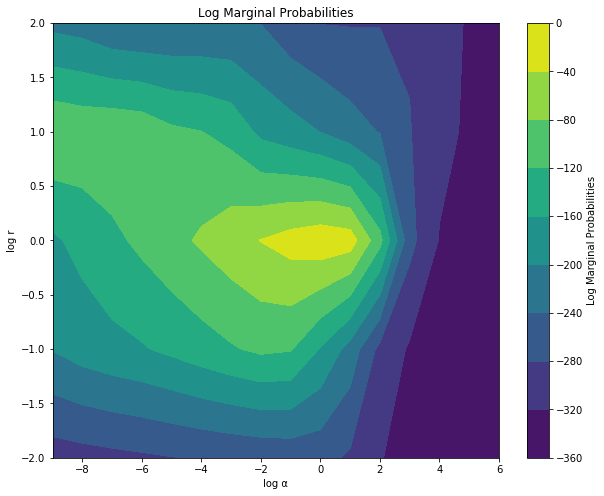

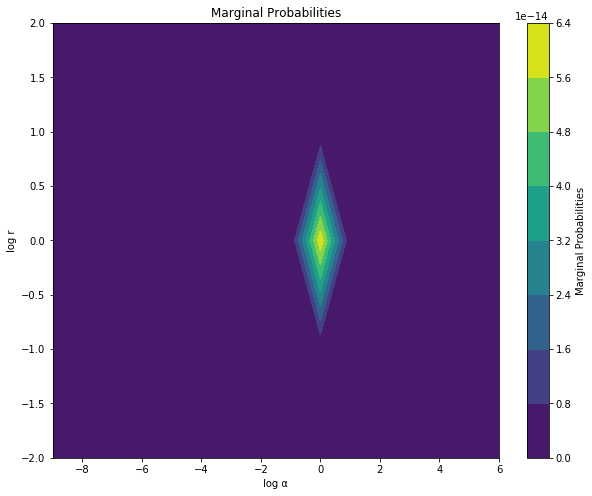

In [7]:
# Hyperparameter posterior visualization

plt.figure(figsize=(10,8))

plt.contourf(x_alpha, x_r, np.transpose(logML_mat))
plt.xlabel('log α')
plt.ylabel('log r')
plt.colorbar().ax.set_ylabel('Log Marginal Probabilities')
plt.title('Log Marginal Probabilities')
plt.show()

plt.figure(figsize=(10,8))

plt.contourf(x_alpha, x_r, np.transpose(ML_mat))
plt.xlabel('log α')
plt.ylabel('log r')
plt.colorbar().ax.set_ylabel('Marginal Probabilities')
plt.title('Marginal Probabilities')
plt.show()

In [8]:
# Hyperparameter values for max logML value 

import math

index = np.argmax(logML_mat)
r_ind = index%5
alpha_ind = math.floor(index/5)
print('Max logML value at:')
print('x_r: ', x_r[r_ind])
print('x_alpha: ', x_alpha[alpha_ind])

Max logML value at:
x_r:  0.0
x_alpha:  0.0


## Task 2: Importance Sampling <a name="task2"></a>


This task focuses on implementing the importance sampling algorithm, and then applying it to find an expected value for basis function width $r$.


### Task 2a

We have the importance sampler function as: 

    Expectations = importance(num_samples, pstar, qstar, qrvs, fun)
    
where:

- `num_samples` is the number of samples desired
- `pstar` is a function object which takes an array argument `x = [logalpha, logr]` and returns $P^\ast(\log\alpha, \log r)$
- `qstar` is a function object which takes an array argument `x = [logalpha, logr]` and returns the p.d.f. $Q(\log \alpha,\log r)$
- `qrvs` is a function object which takes no argument, and generates a single sample of both $\log\alpha$ and $\log r$ from $Q(\log\alpha,\log r)$
- `fun` is the function of `x = [logalpha, logr]` to be weighted in the expectation (which will be simply $r$, see the equation in Task 2b which follows)

The sampler returns `Expectations`: an array of `num_samples` expectations as computed for each sample step (you will need to accumulate these values as you go along), the last element of which will be the final expected value of `fun`. Graphing this array will help us assess the convergence of the sampler (Task 2b).


In [9]:

def importance(num_samples, log_pstar, log_qstar, qrvs, fun):
    
    """This function implements the importance sampling 
       algorithm and returns the expectation values for 
       log r.
       
       Arguments
       ---------
       num_samples: number of samples
       log_pstar: the function returns the log_pstar value for a given x=[log_alpha, log_r] value
       log_qstar: the function returns the log_qstar value for a given x=[log_alpha, log_r] value
       qrvs: the fuction generates a random x=[log_alpha, log_r] value
       fun: converts log r to r
       
       Returns
       -------
       Expectations: set of expected values of log r
       """
    
    x_samples = []
    r_weights = []
    
    Expectations = []
    
    for n in range(0,num_samples):
        x = qrvs()
        x_samples.append(fun(x))                    # store all r values
        r_weight = log_pstar(x)-log_qstar(x)        # as the values are in log ../.. becomes log.. - log.. 
        r_weights.append(r_weight)                  # store all weight values
        
        e = (np.array(x_samples) * np.array(r_weights)).sum()/np.array(r_weights).sum()   # calculate Expectation at every iteration
        Expectations.append(e)
        
    return Expectations 

### Task 2b

Calculate the expected value of $\langle{}r\rangle$ under the posterior $p(\alpha, r | \mathbf{t})$ investigated above, using importance sampling. Assume that $\sigma^2=0.2^2$ is known. That is, compute (via a sampling approximation):
$$ 
\langle{}r\rangle = \int r . p(\alpha, r | \mathbf{t})\, d\alpha\, dr
$$
 

A key question will be how to define $Q(\log\alpha,\log r)$. You are free to experiment, but in your output below you should show results for the following three proposal distribution options:

1. A uniform $Q(\log\alpha,\log r)$, within the full ranges for $\log\alpha$ and $\log r$ suggested for the visualisation of Task 1b above
2. A Gaussian centred at the midpoint of the visualisation, with standard deviation 1/6th of the range in the $\log\alpha$ and $\log r$ directions (*i.e.* one that can reasonably be expected to sample across the entire graph)
3. A Gaussian located at the maximum point you found earlier, $\log\alpha_{\mathrm{MP}}$ and $\log r_{\mathrm{MP}}$, with smaller standard deviation of your choosing (tune this to give more efficient results than 2.) Ideally, your proposal should be broad enough to cover the vast majority of the probability mass of $P^\ast(\alpha, r)$, but no broader.



#### Uniform 

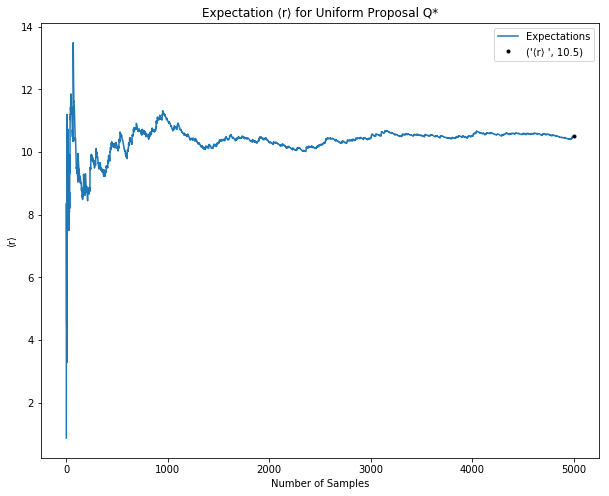

In [10]:
from scipy.stats import uniform

def log_pstar(x):
    RBF = lab2.RBFGenerator(centres, 10**x[1]) 
    PHI = RBF.evaluate(x_train)
    log_pstar = lab2.compute_log_marginal(PHI_train, t_train, 10**x[0], s2)
    return log_pstar

def qrvs():
    ran_logalpha = np.random.uniform(-9,6)      # generates random value for log alpha with equal probability
    ran_logr = np.random.uniform(-2,2)          # generates random value for log r with equal probability
    x = [ran_logalpha, ran_logr]
    return x

def log_qstar(x):
    pdf_logalpha = 1.0/(6.0-(-9.0))
    pdf_logr = 1.0/(2.0-(-2.0))
    pdf_all = pdf_logalpha*pdf_logr             # joint pdf of log alpha and log r
    qstar = pdf_all
    log_qstar = np.log10(qstar)
    return log_qstar

def fun(x):
    r = 10**x[1]
    return r

num_samples = 5000
Expectations = importance(num_samples, log_pstar, log_qstar, qrvs, fun)

plt.figure(figsize=(10,8))
plt.plot(Expectations, label='Expectations')
plt.plot(5000, Expectations[-1], 'k.', label=('⟨r⟩ ', round(Expectations[-1],2)))
plt.legend(loc='best')
plt.xlabel('Number of Samples')
plt.ylabel('⟨r⟩')
plt.title('Expectation ⟨r⟩ for Uniform Proposal Q*')
plt.show()

#### Gaussian at center

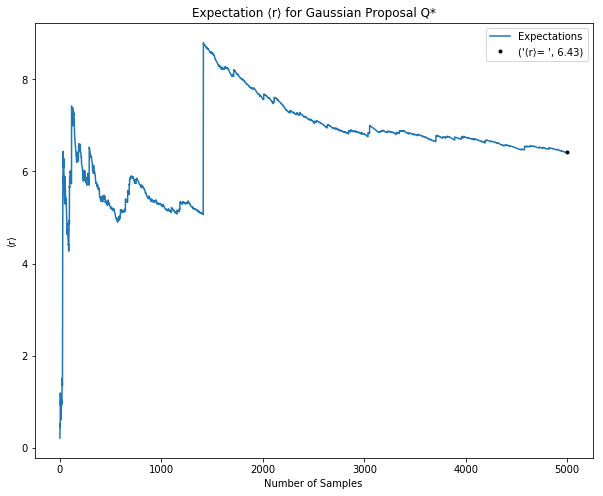

In [11]:
from scipy.stats import multivariate_normal

def log_pstar(x):
    RBF = lab2.RBFGenerator(centres, 10**x[1]) 
    PHI = RBF.evaluate(x_train)
    log_pstar = lab2.compute_log_marginal(PHI_train, t_train, 10**x[0], s2)
    return log_pstar

def qrvs():
    Mu = [-1.5, 0]                          # Gaussian centre
    Cov = [[2.5, 0],[0, 0.67]]              # 16/6 and 5/6     
    model = multivariate_normal(Mu, Cov)    # Gaussian model
    x = model.rvs()
    return x

def log_qstar(x):
    Mu = [-1.5, 0]
    Cov = [[2.5, 0],[0, 0.67]]
    model = multivariate_normal(Mu, Cov)
    qstar = model.pdf(x)
    log_qstar = np.log10(qstar)
    return log_qstar


def fun(x):
    r = 10**x[1]
    return r

num_samples = 5000
Expectations = importance(num_samples, log_pstar, log_qstar, qrvs, fun)

plt.figure(figsize=(10,8))
plt.plot(Expectations, label='Expectations')
plt.plot(5000, Expectations[-1], 'k.',label=('⟨r⟩= ', round(Expectations[-1],2)))
plt.legend(loc='best')
plt.xlabel('Number of Samples')
plt.ylabel('⟨r⟩')
plt.title('Expectation ⟨r⟩ for Gaussian Proposal Q*')
plt.show()

#### Gaussian at max point

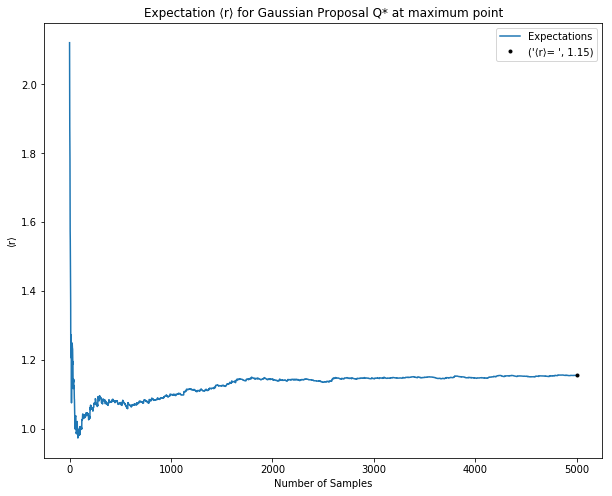

In [12]:
from scipy.stats import multivariate_normal

def log_pstar(x):
    RBF = lab2.RBFGenerator(centres, 10**x[1]) 
    PHI = RBF.evaluate(x_train)
    log_pstar = lab2.compute_log_marginal(PHI_train, t_train, 10**x[0], s2)
    return log_pstar

def qrvs():
    Mu = [1, 0]                          # logML max point
    Cov = [[1.4, 0],[0, 0.06]]           # Tuned covariance matrix
    model = multivariate_normal(Mu, Cov) # Tuned Gaussian model 
    x = model.rvs()
    return x

def log_qstar(x):
    Mu = [1, 0]
    Cov = [[1.4, 0],[0, 0.06]]
    model = multivariate_normal(Mu, Cov)
    qstar = model.pdf(x)
    log_qstar = np.log10(qstar)
    return log_qstar


def fun(x):
    r = 10**x[1]
    return r

num_samples = 5000
Expectations = importance(num_samples, log_pstar, log_qstar, qrvs, fun)

plt.figure(figsize=(10,8))
plt.plot(Expectations, label='Expectations')
plt.plot(5000, Expectations[-1], 'k.',label=('⟨r⟩= ', round(Expectations[-1],2)))
plt.legend(loc='best')
plt.xlabel('Number of Samples')
plt.ylabel('⟨r⟩')
plt.title('Expectation ⟨r⟩ for Gaussian Proposal Q* at maximum point')
plt.show()

### Task 2c 

For a given proposal distribution, add functionality (basically, an outer loop around your importance sampler) to compute the variance *at each sample step* of the returned `Expectations` vector over repeated runs of the sampler (don't fix the random number seed for each run!). We repeated for all three proposal distributions of Task 2b, and plot the variance against sample number on the same graph.
 


In [13]:
#### Task 2c

#### Importance sampler proposal convergence comparison

#### Output should be a graph showing the variance of the Expectations
#### against sample number, as computed over multiple repetitions, 
#### with all three proposals on the same axis.


#### Uniform

In [14]:
def log_pstar(x):
    RBF = lab2.RBFGenerator(centres, 10**x[1]) 
    PHI = RBF.evaluate(x_train)
    log_pstar = lab2.compute_log_marginal(PHI_train, t_train, 10**x[0], s2)
    return log_pstar

def qrvs():
    ran_logalpha = np.random.uniform(-9,6)
    ran_logr = np.random.uniform(-2,2)
    x = [ran_logalpha, ran_logr]
    return x

def log_qstar(x):
    pdf_logalpha = 1.0/(6.0-(-9.0))
    pdf_logr = 1.0/(2.0-(-2.0))
    pdf_all = pdf_logalpha*pdf_logr
    qstar = pdf_all
    log_qstar = np.log10(qstar)
    return log_qstar

def fun(x):
    r = 10**x[1]
    return r

Exp_p1 = [] 
for i in range(100):
    num_samples = 1000
    temp_exp = importance(num_samples, log_pstar, log_qstar, qrvs, fun)
    Exp_p1.append(temp_exp)

    
var_Exp_p1 = np.var(Exp_p1, axis=0)

print('Done!')

Done!


#### Broad Gaussian 

In [15]:
def log_pstar(x):
    RBF = lab2.RBFGenerator(centres, 10**x[1]) 
    PHI = RBF.evaluate(x_train)
    log_pstar = lab2.compute_log_marginal(PHI_train, t_train, 10**x[0], s2)
    return log_pstar

def qrvs():
    Mu = [-1.5, 0]
    Cov = [[2.5, 0],[0, 0.67]]      
    model = multivariate_normal(Mu, Cov)
    x = model.rvs()
    return x

def log_qstar(x):
    Mu = [-1.5, 0]
    Cov = [[2.5, 0],[0, 0.67]]
    model = multivariate_normal(Mu, Cov)
    qstar = model.pdf(x)
    log_qstar = np.log10(qstar)
    return log_qstar


def fun(x):
    r = 10**x[1]
    return r

Exp_p2 = [] 
for i in range(100):
    num_samples = 1000
    temp_exp = importance(num_samples, log_pstar, log_qstar, qrvs, fun)
    Exp_p2.append(temp_exp)

    
var_Exp_p2 = np.var(Exp_p2, axis=0)

print('Done!')

Done!


#### Tuned Gaussian 

In [16]:
def log_pstar(x):
    RBF = lab2.RBFGenerator(centres, 10**x[1]) 
    PHI = RBF.evaluate(x_train)
    log_pstar = lab2.compute_log_marginal(PHI_train, t_train, 10**x[0], s2)
    return log_pstar

def qrvs():
    Mu = [1, 0]
    Cov = [[1.4, 0],[0, 0.06]]
    model = multivariate_normal(Mu, Cov)
    x = model.rvs()
    return x

def log_qstar(x):
    Mu = [1, 0]
    Cov = [[1.4, 0],[0, 0.06]]
    model = multivariate_normal(Mu, Cov)
    qstar = model.pdf(x)
    log_qstar = np.log10(qstar)
    return log_qstar


def fun(x):
    r = 10**x[1]
    return r

Exp_p3 = [] 
for i in range(100):
    num_samples = 1000
    temp_exp = importance(num_samples, log_pstar, log_qstar, qrvs, fun)
    Exp_p3.append(temp_exp)

    
var_Exp_p3 = np.var(Exp_p3, axis=0) 

print('Done!')

Done!


#### Variance Convergence Graphs

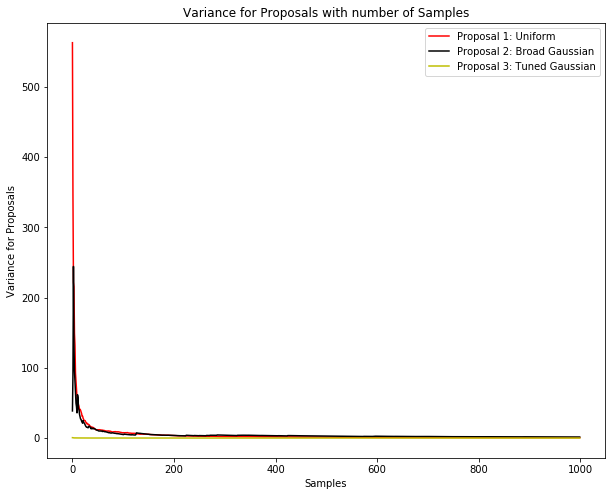

In [17]:
plt.figure(figsize=(10,8))
plt.plot(var_Exp_p1, 'r', label='Proposal 1: Uniform')
plt.plot(var_Exp_p2, 'k', label='Proposal 2: Broad Gaussian')
plt.plot(var_Exp_p3, 'y', label='Proposal 3: Tuned Gaussian')
plt.legend(loc='best')
plt.xlabel('Samples')
plt.ylabel('Variance for Proposals')
plt.title('Variance for Proposals with number of Samples')
plt.show()

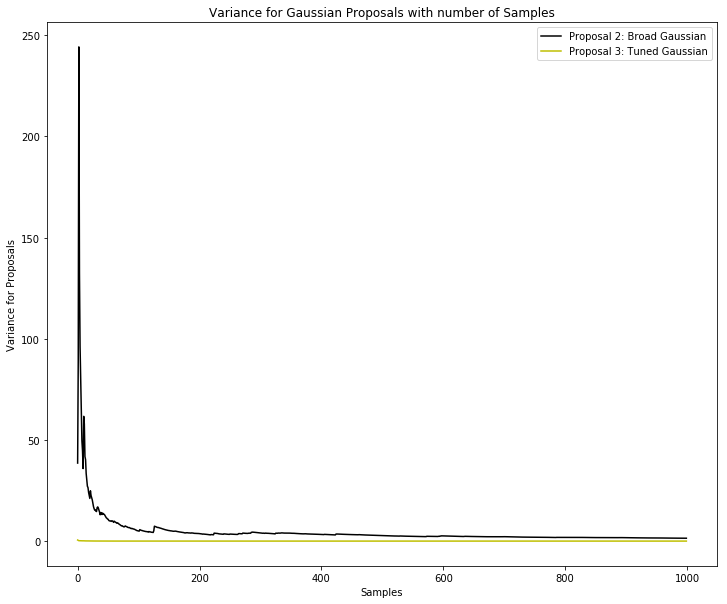

In [18]:
plt.figure(figsize=(12,10))
plt.plot(var_Exp_p2, 'k', label='Proposal 2: Broad Gaussian')
plt.plot(var_Exp_p3, 'y', label='Proposal 3: Tuned Gaussian')
plt.legend(loc='best')
plt.xlabel('Samples')
plt.ylabel('Variance for Proposals')
plt.title('Variance for Gaussian Proposals with number of Samples')
plt.show()

## Task 3: MCMC & The Metropolis Algorithm <a name="task3"></a>

This task focuses on implementing the Metropolis, MCMC sampling, algorithm, and again applying the sampler to find the expected value for basis function width $r$. This is also extended to estimation of the noise variance $\sigma^2$ and (bonus task) the weights $\mathbf{w}$.


### Task 3a

The algorithm be implemented is as follows:

    samples, rejected = metropolis(num_samples, pstar, qrvs, x0)

- `num_samples` is the number of samples desired
- `pstar` is a function object which takes an array argument `x` and returns the corresponding $P^\ast(x)$, for example where `x = [log alpha, log r]`
- `qrvs` is a function object which takes a single argument `x` (current state), and generates a single proposal `xdash` sampled from $Q(x'|x)$
- `x0` is the starting state (experiment!)


In [19]:
#### **** YOUR CODE HERE **** ####

#### Task 3a

#### Metropolis algorithm implementation

def metropolis(num_samples, pstar, qrvs, x0):
    
    """This function implements the Metropolis
       algorithm and returns all the samples 
       and rejected samples.
       
       Arguments
       ---------
       num_samples: number of samples
       pstar: the function returns the pstar value for a given x=[log_alpha, log_r] value
       qrvs: the fuction generates a random x=[log_alpha, log_r] value
       fun: converts log r to r
       
       Returns
       -------
       samples: all the samples taken into consideration
       rejected: all the samples rejected
       """
    
    samples = []
    rejected = []
    current_state = x0
    
    for n in range(num_samples):
        xdash = qrvs(current_state)
        pstar_xdash = pstar(xdash)
        pstar_x = pstar(current_state)
        k = pstar_xdash/pstar_x
    
        if k>=1:                     # Accept xdash
            current_state = xdash
            samples.append(xdash)
        else:                        # Accept xdash
            if np.random.rand() < k:
                current_state = xdash
                samples.append(xdash)
            else:                    # Reject xdash
                samples.append(current_state)
                rejected.append(xdash)
    
    return samples, rejected



### Task 3b

Calculate the expected value of $\langle{}r\rangle$ under the posterior $p(\alpha, r | \mathbf{t})$ investigated above, using MCMC sampling as implemented by your Metropolis algorithm. Assume that $\sigma^2=0.2^2$ is known. The overall setup should be exactly the same as for the importance sampler, but with a different sampling algorithm. As you may realise, you can re-use the same `pstar` function, although you will need to change `qstar` and create a new `qrvs` to reflect the change in algorithm.

A multivariate Gaussian for $Q$, but experiment with three different length scales (standard deviations):

1. one too narrow, which has a very high acceptance rate (anything over 80%), and which "random walks" 
2. one too broad, which has a low acceptance rate (say, around 5%)
2. one "just right", with acceptance rate between 20% and 30% (see below hint)

With the sampler, for each proposal we have:

- calculate and output the acceptance rate, which if you have coded it conventionally, should be `(num_samples-len(rejected)) / num_samples`
- plot the usual graph showing convergence: *i.e.* a graph of $\langle r\rangle$ with increasing sample number (exactly as done in Task 2b).
- print out the final value of $\langle r\rangle$ (the last point on the graph)
- re-create the earlier visualisation of $p(\alpha, r | \mathbf{t})$ and overlay the samples (optionally, you might also plot the rejected proposals too). It is suggested you also include the "burn in" samples here (but exclude them when calculating $\langle r\rangle$ - see note below)


In [20]:
#### Task 3b

#### Test the Metropolis algorithm implementation

#### For each of the three proposals, the output should be
#### - print out of the length-scale used for the proposal
#### - print out of the acceptance rate
#### - plot of convergence: <r> against sample number
#### - print out of the final value of <r>
#### - replot the previous visualisation, and overlay the samples (as a scatter plot on top)
####


#### Q with high acceptance rate : Above 80%

Broad Scale with high acceptance rate
Acceptance Rate:  80.0 %


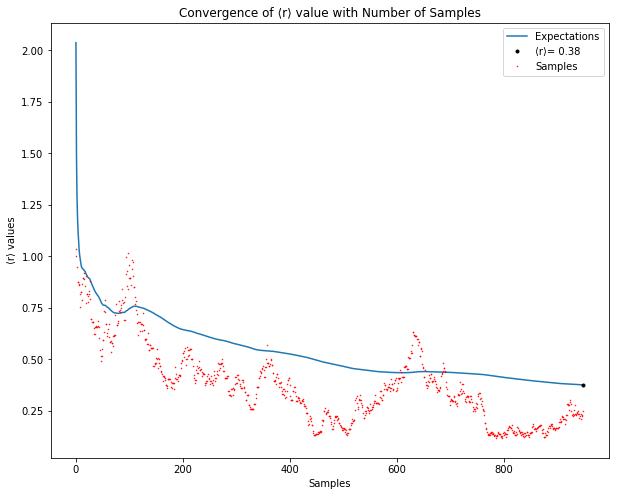

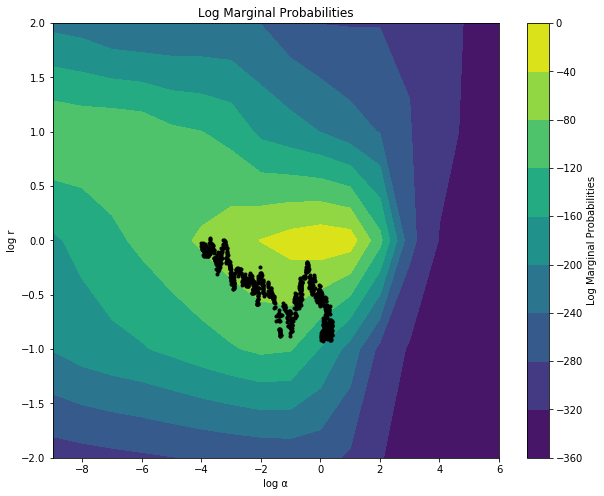

In [21]:
from scipy.stats import multivariate_normal

# Define pstar, qrvs, x0 and num_samples
def pstar(x):
    RBF = lab2.RBFGenerator(centres, 10**x[1]) 
    PHI = RBF.evaluate(x_train)
    log_pstar = lab2.compute_log_marginal(PHI_train, t_train, 10**x[0], s2)
    pstar = 10**log_pstar
    return pstar

qrvs = lambda x: stats.multivariate_normal.rvs(size=1, mean=x, cov=[0.0005, 0.001])

x0 = [-4, 0]

num_samples = 1000
samples_tag = [s for s in range(1,num_samples)]

samples, rejected = metropolis(num_samples, pstar, qrvs, x0)


# Calculate acceptance rate
acceptance_rate = (num_samples - len(rejected))*100/num_samples
print('Broad Scale with high acceptance rate')
print('Acceptance Rate: ', acceptance_rate,'%')


log_r = [r[1] for r in samples]
r = np.power(10, log_r)
log_alpha = [r[0] for r in samples]


# Incorporate burn in of 5%
r = r[51:]


# Calculate expectation values for r
Exp_r_sums = np.cumsum(r, axis=0)

Exp_r = []
for e in range(1, len(Exp_r_sums)):
    exp_r = Exp_r_sums[e]/(e*1.0)
    Exp_r.append(exp_r)


# Convergence graph for <r>    
plt.figure(figsize=(10,8))
plt.plot(Exp_r, label='Expectations') # Plotting values after Burn in
plt.plot(949, Exp_r[-1], 'k.',label=('⟨r⟩= %.2f' %Exp_r[-1]))
plt.plot(r, 'ro', markersize=0.5, label='Samples')
plt.legend(loc='best')
plt.ylabel('⟨r⟩ values')
plt.xlabel('Samples')
plt.title('Convergence of ⟨r⟩ value with Number of Samples')
plt.show()


# Length-scale proposal with sample overlay
plt.figure(figsize=(10,8))
plt.contourf(x_alpha, x_r, np.transpose(logML_mat))
plt.plot(log_alpha, log_r, 'k.')
plt.xlabel('log α')
plt.ylabel('log r')
plt.colorbar().ax.set_ylabel('Log Marginal Probabilities')
plt.title('Log Marginal Probabilities')
plt.show()

#### Q with low acceptance rate : 5%

Narrow Scale with low acceptance rate
Acceptance Rate:  4.5 %


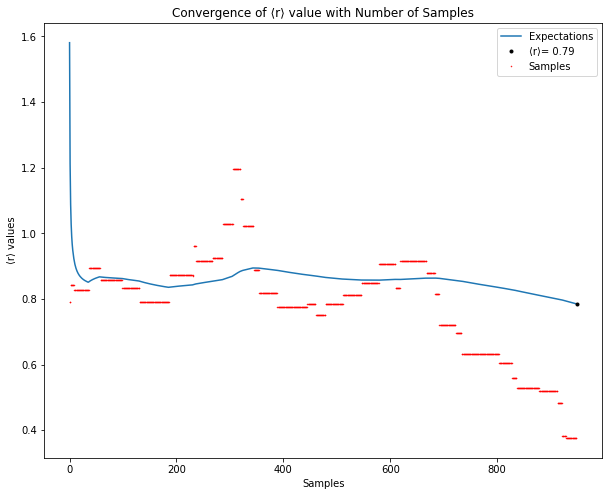

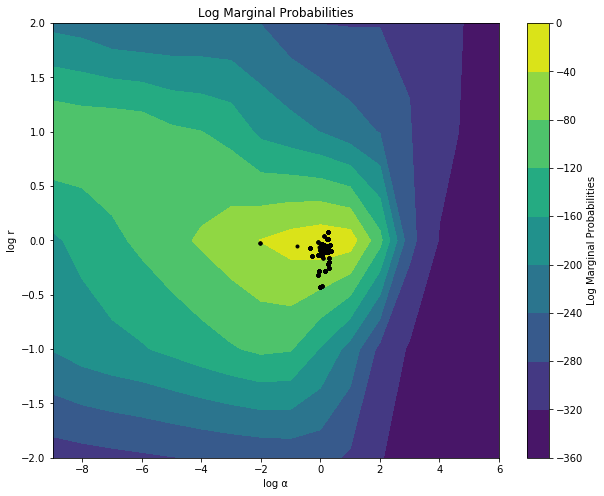

In [22]:
from scipy.stats import multivariate_normal

def pstar(x):
    RBF = lab2.RBFGenerator(centres, 10**x[1]) 
    PHI = RBF.evaluate(x_train)
    log_pstar = lab2.compute_log_marginal(PHI_train, t_train, 10**x[0], s2)
    pstar = 10**log_pstar
    return pstar

qrvs = lambda x: stats.multivariate_normal.rvs(size=1, mean=x, cov=[10, 0.001])

x0 = [-4, 0]

num_samples = 1000
samples, rejected = metropolis(num_samples, pstar, qrvs, x0)

# Calculate acceptance rate
acceptance_rate = (num_samples - len(rejected))*100/num_samples
print('Narrow Scale with low acceptance rate')
print('Acceptance Rate: ', acceptance_rate,'%')

log_r = [r[1] for r in samples]
r = np.power(10, log_r)

log_alpha = [r[0] for r in samples]

# Include burn in of 5%
r = r[51:]

# Calculate expectation values for r
Exp_r_sums = np.cumsum(r, axis=0)

Exp_r = []
for e in range(1, len(Exp_r_sums)):
    exp_r = Exp_r_sums[e]/(e*1.0)
    Exp_r.append(exp_r)


# Convergence graph for <r>
plt.figure(figsize=(10,8))
plt.plot(Exp_r, label='Expectations') # Plotting values after Burn in
plt.plot(949, Exp_r[-1], 'k.',label=('⟨r⟩= %.2f' %Exp_r[-1]))
plt.plot(r, 'ro', markersize=0.5, label='Samples')
plt.legend(loc='best')
plt.ylabel('⟨r⟩ values')
plt.xlabel('Samples')
plt.title('Convergence of ⟨r⟩ value with Number of Samples')
plt.show()


# Length-scale proposal with sample overlay
plt.figure(figsize=(10,8))
plt.contourf(x_alpha, x_r, np.transpose(logML_mat))
plt.plot(log_alpha, log_r, 'k.')
plt.xlabel('log α')
plt.ylabel('log r')
plt.colorbar().ax.set_ylabel('Log Marginal Probabilities')
plt.title('Log Marginal Probabilities')
plt.show()

#### Q with good acceptance rate : 25%

Appropriate Scale with good acceptance rate
Acceptance Rate:  22.1 %


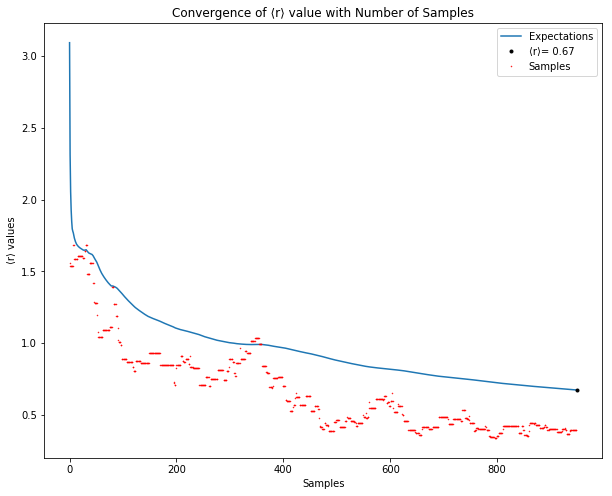

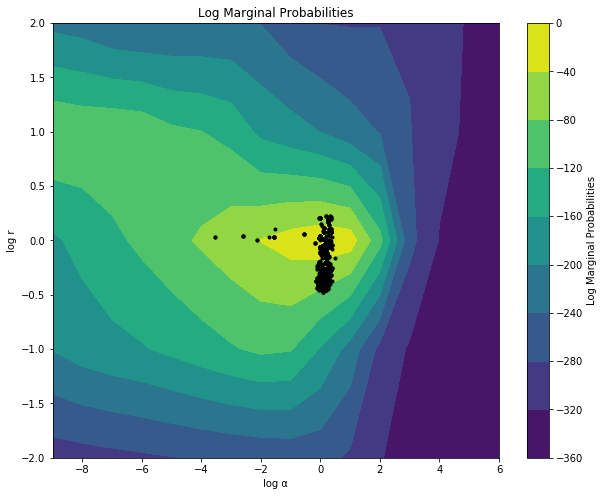

In [23]:
from scipy.stats import multivariate_normal

def pstar(x):
    RBF = lab2.RBFGenerator(centres, 10**x[1]) 
    PHI = RBF.evaluate(x_train)
    log_pstar = lab2.compute_log_marginal(PHI_train, t_train, 10**x[0], s2)
    pstar = 10**log_pstar
    return pstar

qrvs = lambda x: stats.multivariate_normal.rvs(size=1, mean=x, cov=[0.4, 0.001])

x0 = [-4, 0]

num_samples = 1000
samples, rejected = metropolis(num_samples, pstar, qrvs, x0)

# Calculate acceptance rate
acceptance_rate = (num_samples - len(rejected))*100/num_samples
print('Appropriate Scale with good acceptance rate')
print('Acceptance Rate: ', acceptance_rate,'%')

log_r = [r[1] for r in samples]
r = np.power(10, log_r)

log_alpha = [r[0] for r in samples]

# Include burn in of 5%
r = r[51:]

# Calculate expectation values for r
Exp_r_sums = np.cumsum(r, axis=0)

Exp_r = []
for e in range(1, len(Exp_r_sums)):
    exp_r = Exp_r_sums[e]/(e*1.0)
    Exp_r.append(exp_r)


# Convergence graph for <r>    
plt.figure(figsize=(10,8))
plt.plot(Exp_r, label='Expectations') # Plotting values after Burn in
plt.plot(949, Exp_r[-1], 'k.',label=('⟨r⟩= %.2f' %Exp_r[-1]))
plt.plot(r, 'ro', markersize=0.5, label='Samples')
plt.legend(loc='best')
plt.ylabel('⟨r⟩ values')
plt.xlabel('Samples')
plt.title('Convergence of ⟨r⟩ value with Number of Samples')
plt.show()

# Length-scale proposal with sample overlay
plt.figure(figsize=(10,8))
plt.contourf(x_alpha, x_r, np.transpose(logML_mat))
plt.plot(log_alpha, log_r, 'k.')
plt.xlabel('log α')
plt.ylabel('log r')
plt.colorbar().ax.set_ylabel('Log Marginal Probabilities')
plt.title('Log Marginal Probabilities')
plt.show()

### Task 3c: Extend Metropolis sampler to estimate the noise variance $\sigma^2$

Extend the above example to include the noise variance $\sigma^2$. Assume a uniform log prior as usual, and sample in $\log \sigma^2$ space. 

In [24]:
#### Task 3c

#### Extend the Metropolis sampler to estimate the noise std dev

#### Output should be
#### - print out of the length-scale used for the proposal
#### - print out of the acceptance rate
#### - plot of convergence: <s2> against sample number
#### - print out of the final estimate of noise standard deviation


Appropriate Scale with good acceptance rate
Acceptance Rate:  4.3 %
Final estimate of noise standard deviation s2: 0.04


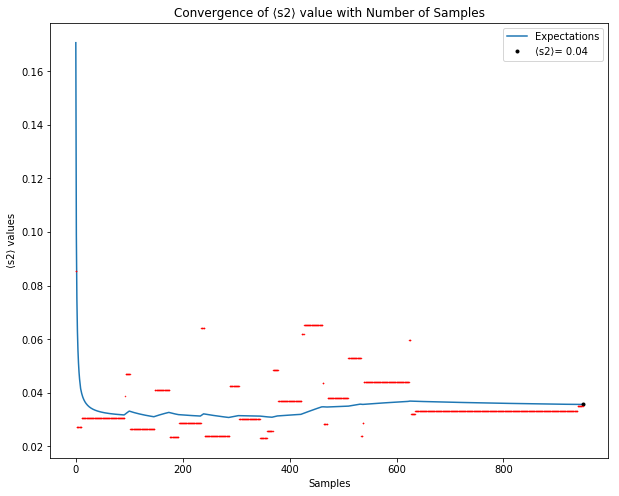

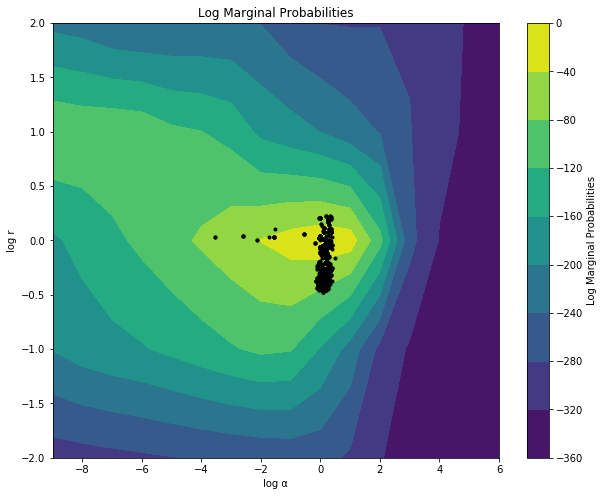

In [25]:

def pstar_s2(x):
    
    """Arguments
       ---------
       x[0]: log alpha
       x[1]: log r
       x[2]: log s2
       """
    RBF = lab2.RBFGenerator(centres, 10**x[1]) 
    PHI = RBF.evaluate(x_train)
    log_pstar = lab2.compute_log_marginal(PHI_train, t_train, 10**x[0], 10**x[2])
    pstar = 10**log_pstar
    return pstar

qrvs_s2 = lambda x: stats.multivariate_normal.rvs(size=1, mean=x, cov=[0.4, 0.001, 1.5])

x0s2 = [-4, 0, 0]

num_samples = 1000
samples_s2, rejected_s2 = metropolis(num_samples, pstar_s2, qrvs_s2, x0s2)

# Calculate acceptance rate
acceptance_rate = (num_samples - len(rejected_s2))*100/num_samples
print('Appropriate Scale with good acceptance rate')
print('Acceptance Rate: ', acceptance_rate,'%')

log_s2 = [s2[2] for s2 in samples_s2]
s2 = np.power(10, log_s2)

# Include burn in of 5%
s2 = s2[51:]

# Calculate expectation values for s2
Exp_s2_sums = np.cumsum(s2, axis=0)

Exp_s2 = []
for e in range(1, len(Exp_s2_sums)):
    exp_s2 = Exp_s2_sums[e]/(e*1.0)
    Exp_s2.append(exp_s2)

print("Final estimate of noise standard deviation s2: %.2f" %Exp_s2[-1])

# Convergence graph for <s2>
plt.figure(figsize=(10,8))
plt.plot(Exp_s2, label='Expectations') # Plotting values after Burn in
plt.plot(949, Exp_s2[-1], 'k.',label=('⟨s2⟩= %.2f' %Exp_s2[-1]))
plt.plot(s2, 'ro', markersize=0.5)
plt.legend(loc='best')
plt.ylabel('⟨s2⟩ values')
plt.xlabel('Samples')
plt.title('Convergence of ⟨s2⟩ value with Number of Samples')
plt.show()

# Length-scale proposal with sample overlay
plt.figure(figsize=(10,8))
plt.contourf(x_alpha, x_r, np.transpose(logML_mat))
plt.plot(log_alpha, log_r, 'k.')
plt.xlabel('log α')
plt.ylabel('log r')
plt.colorbar().ax.set_ylabel('Log Marginal Probabilities')
plt.title('Log Marginal Probabilities')
plt.show()

### Task 3d: Be "strictly Bayesian" and sample all the model unknowns to derive the mean predictor 

Extend your Metropolis algorithm to sample over *all* the unknowns in the model: that is, not just $\alpha$, $\sigma$, $r$ as in Task 3c, but also the weights $\mathbf{w}$. This is slightly artificial, in that we don't really need to sample the weights in this model (the posterior over $\mathbf{w}$ is analytically computable), but it demonstates the principle. In a neural network model (which will be nonlinear in $\mathbf{w}$), we *will* need to sample.

The objective of this task is to plot the "average" predictor at the points `x_test` (you may re-use `plot_regression` for the actual graphing). The quantity to be found is:

$$
\langle \mathbf{y} \rangle = \int (\mathbf{\Phi_\ast} \mathbf{w}) . p(\mathbf{w}, \alpha, r, \sigma^2 | \mathbf{t})\, d\mathbf{w}\, d\alpha\, dr\, d\sigma^2,
$$
where $\mathbf{\Phi_\ast}$ is the basis matrix evaluated at `x_test`.

You will need to set up your Metropolis algorithm to sample from $p(\mathbf{w}, \alpha, r, \sigma^2 | \mathbf{t})$. This is of course given by Bayes' rule:

$$
p(\mathbf{w}, \alpha, r, \sigma^2 | \mathbf{t}) = \frac{p(\mathbf{t}|\mathbf{w}, r, \sigma^2)\,p(\mathbf{w}| \alpha)\,p(\alpha)\,p(r)\,p(\sigma^2)}{p(\mathbf{t})}.
$$
From this, we can identify
$$
P^\ast(\mathbf{w}, \alpha, r, \sigma^2) = p(\mathbf{t}|\mathbf{w}, r, \sigma^2)\, p(\mathbf{w}| \alpha)\, p(\alpha)\,p(r)\, p(\sigma^2)
$$
where

- $p(\mathbf{t}|\mathbf{w}, \sigma^2)$ is the Gaussian likelihood probability model (Lecture 3, slide 13)
- $p(\mathbf{w}| \alpha)$ is the Gaussian weight prior (Lecture 3, slide 15)
- $p(\alpha)$, $p(r)$ and $p(\sigma^2)$ are hyperpriors, which if defined as uniform over $\log\alpha$, $\log r$ and $\log\sigma$ respectively, may be considered constant

The state space here will be 19-dimensional, due to the 16 weights combined with $\alpha$, $r$ and $\sigma^2$. A relatively narrow Gaussian proposal distribution $Q(\theta^\prime| \theta)$ should work OK, though you may wish to experiment with the length scales. Ideally, you would use different length scales for the three parameter types, though this is an unnecessary complication in the context of this exercise (no marks deducted for not doing it).



In [26]:
#### Task 3d

#### Extend the Metropolis sampler to estimate the noise std dev

#### Output should be
#### - a single plot of the mean predictor
#### - [optional] estimate of sigma
####


In [27]:
best_r = 1.17
rbf = lab2.RBFGenerator(centres, best_r)
new_PHI_train = rbf.evaluate(x_train)

In [28]:
from scipy.stats import multivariate_normal

qrvs = lambda X, COV: multivariate_normal.rvs(size=1, mean=X, cov=COV)

def pstar(w, alph, s2, y, PHI):
    """Reimplementing pstar to handle posterior weights."""
    N,M = PHI.shape
    # p1 is P(y|w,σ2)
    p1 = np.prod(multivariate_normal.pdf(y-np.dot(PHI,w).reshape(N,1),mean=None,cov=s2))
    # p2 is P(w|α)
    p2 = np.prod(multivariate_normal.pdf(w,mean=None,cov=alph**(-1)))
    # prob is P∗(w,α,σ2)
    prob = p1 * p2     
                 
    return prob

def Metropolis(PHI, y, K = 10000, scale = 0.001, burn_rate = 0.1):
    """Reimplementing Metropolis algorithm to handle posterior weights."""
    if y.ndim == 1:
        y = y.reshape(-1, 1)
    N,M = PHI.shape
    X0 = np.zeros(M+2)
    COV = np.eye(M+2,M+2)*scale
    current_state = X0
    accept = []
    reject = []
    for i in range(K):
        next_state = qrvs(current_state, COV)
        p_new = pstar(next_state[:-2], np.exp(next_state[-2]), np.exp(next_state[-1]), y, PHI)
        p_old = pstar(current_state[:-2], np.exp(current_state[-2]), np.exp(current_state[-1]), y, PHI)
        
        p = p_new/p_old
        
        if p >= 1 :
            accept.append(next_state)
            current_state = next_state
        else:
            if np.random.rand() < p:
                accept.append(next_state)
                current_state = next_state
            else:
                reject.append(next_state)
                accept.append(current_state)
                
    reject_rate = len(reject)/K
    print('Rejection rate is', reject_rate*100, '%')
    
    # burn in
    start_point = round(len(accept) * burn_rate)
    weights = np.array(accept)[start_point:].mean(axis = 0)
    
    return weights[:-2]

In [29]:
def predict(target_PHI, weights):
    
    prediction = np.dot(target_PHI, weights)
    
    return prediction

weights3 = Metropolis(new_PHI_train, t_train, K = 10000, scale = 0.001, burn_rate = 0.05)
t_train_pred3 = predict(PHI_train, weights3)
t_test_pred3 = predict(PHI_test, weights3)

Rejection rate is 39.33 %


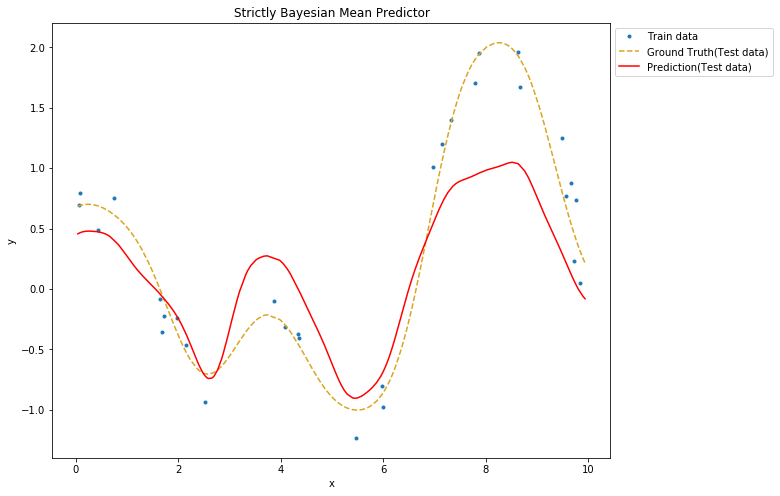

In [31]:

plt.figure(figsize=(10,8))
plt.plot(x_train, t_train, '.', label = 'Train data')
plt.plot(x_test, t_test,'--', color='goldenrod', label = 'Ground Truth(Test data)')
plt.plot(x_test, t_test_pred3, c ='r', label = 'Prediction(Test data)')
plt.legend(loc='upper left', bbox_to_anchor=(1.0,1.0))
plt.xlabel('x')
plt.ylabel('y')
plt.title('Strictly Bayesian Mean Predictor')
plt.show()